# Методы ценообразования опционов.Часть 3.
> выполнил Литвинов А. А., гр. МФИН211

* <font size='5'>Black-Scholes</font>
* <font size='5'>Finite-difference methods (методы конечных разностей)</font>

## 1.Загрузка библиотек

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import scipy.linalg 
from scipy import stats
from scipy.sparse import diags
from scipy.linalg import lu

## 2.Классы, необходимые для реализации моделей ценообразования опционов

### Black-Scholes 

In [2]:
class BSM:
        def __init__(self,S_0,K,r,T,sigma,div=0,t=0,is_call=True):
            self._S_0=S_0
            self._K=K
            self._r=r
            self._div=div
            self._T=T
            self._sigma=sigma
            self._t=t
            self._is_call=is_call  
       
        def __d_values__(self):
            self._d1=(np.log(self._S_0/self._K)+(self._r-self._div+0.5*self._sigma**2)*(self._T-self._t))/(self._sigma*np.sqrt(self._T-self._t))
            self._d2=self._d1-self._sigma*np.sqrt(self._T-self._t)
            
        def __N_d__(self,d_value):
            return stats.norm.cdf(d_value)
        
        def __price__(self):
            return (np.exp(-self._div*\
            (self._T-self._t))*self._S_0*self.__N_d__(self._d1)-np.exp(-self._r*\
            (self._T-self._t))*self._K*self.__N_d__(self._d2)) if self._is_call \
            else (np.exp(-self._r*(self._T-self._t))*self._K*self.__N_d__(-self._d2)- np.exp(-self._div*\
            (self._T-self._t))*self._S_0*self.__N_d__(-self._d1))
            
        def get_price(self):
            self.__d_values__()
            price=self.__price__()
            return price
        
        def get_delta(self):
            self.__d_values__()
            return self.__N_d__(self._d1) if self._is_call else  self.__N_d__(self._d1)-1
        
        def get_vega(self):
            self.__d_values__()
            return (self._S_0*stats.norm.pdf(self._d1)*np.sqrt(self._T-self._t)*np.exp(-self._div*\
            (self._T-self._t)))/100

### Finite difference methods

In [3]:
class FDM_n:
    def __init__(self,S_0,S_max,K,r,T,sigma,nas,nts,theta,q=0,t=0,is_call=True,is_european=True):
        self._S_0=S_0
        self._S_max=S_max
        self._K=K
        self._r=r
        self._q=q
        self._T=(T-t)/250
        self._sigma=sigma
        self._t=t
        self._nas=nas
        self._nts=nts
        self._theta=theta
        self._is_call=is_call
        self._is_european=is_european
    
    def __get_index__(self):
        return math.floor(self._S_0/self._S_max*self._nas)
        
    def __get_S_array__(self):
        index_1=self.__get_index__()
        index_2=self._nas-index_1
        ds=self._S_0/index_1
       # print(index_1,index_2,ds)
        S_array=np.empty(self._nas)
        S_array[0]=0
        S_array[index_1]=self._S_0
        S_array[1:(index_1)]=np.arange(1,index_1)*ds
        S_array[(index_1+1):self._nas]=self._S_0+np.arange(1,index_2)*ds
       # print(S_array)
        return S_array       
           
    def __get_params__(self):
       # print(self._q)
        start=1
        end=self._nas-1
        array=np.arange(start,end)*(self._r-self._q)
        delta_t=self._T/self._nts
        array_sq=np.square(np.arange(start,end))*self._sigma**2
        A=(1-self._theta)*(delta_t/2)*(-array+array_sq)
        B=1-(1-self._theta)*delta_t*(self._r+array_sq)
        C=(1-self._theta)*(delta_t/2)*(array+array_sq)
        a=self._theta*(delta_t/2)*(array-array_sq)
        b=1+self._theta*delta_t*(self._r+array_sq)
        c=-self._theta*(delta_t/2)*(array+array_sq) 
        return (self.__get_matrix__(a,b,c), self.__get_matrix__(A,B,C),A[0],c[end-2])
    
    def __opt_value__(self,S,value=0):
       # print((S - self._K)-value>0)
        if self._is_call:        
            return np.maximum(S - self._K,value)
        else:
            return np.maximum(self._K-S,value)
    
    def __get_matrix__(self,a,b,c):
            diag_matrix=diags(diagonals=[b,a[1:],c[:-1]],offsets=[0,-1,1]).toarray()
            return diag_matrix

    def __get_rhs__(self, B, opt_val_array,a_1,c_end,val_min,val_max):
        rhs=B.dot(opt_val_array)
        #print(c_end,val_max)
        rhs[0]+=-a_1*val_min
        rhs[-1]+=-c_end*val_max
       # print(rhs[-1])
        return rhs
    
    def __LU_decomposition__(self, matrix_A):
        _, l, u = lu(matrix_A)
        return (l,u)
    
    def __iterations__(self):
        A,B,a_1,c_end=self.__get_params__()
        c_end/=self._theta
        a_1/=self._theta
        S_array=self.__get_S_array__()
        opt_val_array=self.__opt_value__(S_array)
        val_min=opt_val_array[0]
        val_max=opt_val_array[-1]
        start=1
        end=self._nas-1
        RHS=self.__get_rhs__(B,opt_val_array[start:end],a_1,c_end,val_min,val_max)
        #print(RHS)
        vals=np.empty([self._nas,self._nts+1])
        vals[:,0]=S_array
        vals[:,1]=opt_val_array
        L,U=self.__LU_decomposition__(A)
        for j in range(2,self._nts+1):   
            y=np.linalg.solve(L,RHS)
            opt_val_array[start:end]=np.linalg.solve(U,y)
            if self._is_european==False:
               # print('A')
                opt_val_array=self.__opt_value__(S_array,opt_val_array)            
            RHS=self.__get_rhs__(B,opt_val_array[start:end],a_1,c_end,val_min,val_max) 
           # print(RHS)
            vals[:,j]=opt_val_array   
        return np.round(vals,4)  
    
    def get_price(self):
        vals=self.__iterations__()
        df=pd.DataFrame(vals)
        columns=['S']
        columns.extend(list(range(self._nts-1,-1,-1)))
        df.columns=columns
        return df

### Finite difference Greeks

In [4]:
class Greeks_FD:
        def __init__(self,S_0,grid,dt,t=0):
            self._S_0=S_0
            self._grid=grid
            self._t=t
            self._dt=dt
        
        def __get_index__(self):
            index=self._grid.index[self._grid.S==self._S_0].tolist()[0]
            return index
        
        def __get_ds__(self):
            return self._grid.loc[1,'S']-self._grid.loc[0,'S']
        
        def __delta__(self):
            index=self.__get_index__()
            n=self._grid.shape[0]
            ds=self.__get_ds__()
            #print('ds',ds)
            if  ((index-2<0)&(index+2>n)):
                print('Index is near the boundaries')
            else:
                delta=(-self._grid.loc[index+2,self._t]+8*self._grid.loc[index+1,self._t]-8*self._grid.loc[index-1,self._t]+\
                      self._grid.loc[index-2,self._t])/(12*ds)
                return delta
            
        def __gamma__(self):
            index=self.__get_index__()
            n=self._grid.shape[0]# количество шагов актива
            if  ((index-2<0)&(index+2>n)):
                print('Index is near the boundaries')
            else:
                ds=self.__get_ds__()
                gamma=(-self._grid.iloc[index+2,self._t]+16*self._grid.iloc[index+1,self._t]-30*self._grid.iloc[index,self._t]+
                      16*self._grid.iloc[index-1,self._t]-self._grid.iloc[index-2,self._t])/(12*ds**2)
                return gamma
                
        def __theta__(self):
            index=self.__get_index__()
            n=self._grid.shape[1] # количество шагов времени
            if  (self._t+3>n):
                print('Index is near the boundaries')
            else:
                theta=(-self._grid.loc[index,self._t]+8*self._grid.loc[index,self._t+1]-8*self._grid.loc[index,self._t+2]+
                       self._grid.loc[index,self._t+3])/(12*self._dt)
                return theta    
        
        def  get_delta(self):  
            return self.__delta__()
        
        def get_gamma(self):
            return self.__gamma__()
        
        def get_theta(self):
            return self.__theta__()

### Функция, формирующая dataframe c ценами опционов

In [40]:
def to_df(S_0,K,r,days,sigma,nas,nts,div,is_european):
    Imp={}
    #print('d',div)
    for theta in (.5,1):
        call={}
        put={}
        k=0
        for ns in nas:
            for nt in nts: 
                grid_call=FDM_n(S_0,2*K,K,r,days,sigma,ns,nt,theta,q=div,is_call=True,is_european=is_european).get_price()
                call[k]=(grid_call.loc[grid_call.S==S_0,0].tolist(),(ns,nt))
                grid_put=(FDM_n(S_0,2*K,K,r,days,sigma,ns,nt,theta,q=div,is_call=False,is_european=is_european).get_price())
                put[k]=(grid_put.loc[grid_call.S==S_0,0].tolist(),(ns,nt))
                k+=1
        Imp[theta]={'call':call,'put':put}
    option_FD=pd.DataFrame([Imp[0.5]['call'],Imp[0.5]['put'],Imp[1]['call'],Imp[1]['put']]).transpose()
    option_FD.columns=['CN_call','CN_put','FI_call','FI_put']
    option_FD['NAS']=option_FD['CN_call'].apply(lambda x:x[1][0])
    option_FD['NTS']=option_FD['CN_call'].apply(lambda x:x[1][1])
    # df[df.columns[i]]
    option_FD[option_FD.columns[0:4]]=option_FD.iloc[:,0:4].applymap(lambda x:x[0][0])
    cols = option_FD.columns.tolist()
    cols=cols[-2:]+cols[:-2]
    return option_FD[cols]

In [6]:
def get_Greeks(grid,S_0,dt):
    return {'delta':Greeks_FD(S_0,grid,dt).get_delta(), 
            'gamma':Greeks_FD(S_0,grid,dt).get_gamma(),'theta':Greeks_FD(S_0,grid,dt).get_theta()}

## 3.Реализация методов

In [31]:
K=76.5
S_0=74.82
r=0.014
sigma=0.16 # годовое значение
days=250
div=0.01

### 3.1. Black-Scholes

In [32]:
option_call=BSM(S_0,K,r,days/250,sigma,div=div,is_call=True).get_price()
option_call

4.1169372535922015

In [33]:
BSM(S_0,K,r,days/250,sigma,is_call=True).get_delta()

0.5114542730303778

In [34]:
option_put=BSM(S_0,K,r,days/250,sigma,div=div,is_call=False).get_price()
option_put

5.4778708285883795

In [35]:
BSM(S_0,K,r,days/250,sigma,is_call=False).get_delta()

-0.4885457269696222

### Проверка паритет пут-колл для европейского опциона (BS)

In [36]:
K*np.exp(-r*(days/250-0))+option_call

79.55339938970113

In [37]:
np.exp(-div*(days/250-0))*S_0+option_put

79.55339938970113

### 3.2. Finite difference methods

### Для моделирования используется так называемый $\theta$-метод. Данный метод (алгоритм) обобщает различные спецификации модели. Класс, рассматриваемый в примере, реализован для $\theta>0$  и основан на решении системы линейных уравнений. Алгоритм явного метода (explicit), $\theta=0$, реализуется с помощью простого цикла.

* $\theta=0$ - Explicit
* $\theta=1$ - Fully Implicit
* $\theta=0.5$ - Crank-Nikolson

### Модель FD строится для массива шагов цен актива и времени

In [38]:
nas_tuple=(20,50,100)
nts_tuple=(20,50,100)

### Европейский опцион

In [41]:
to_df(S_0,K,r,days,sigma,nas_tuple,nts_tuple,div=div,is_european=True)

,NAS,NTS,CN_call,CN_put,FI_call,FI_put
0,20,20,3.8612,5.2379,3.8257,5.2026
1,20,50,3.9386,5.3058,3.9246,5.2919
2,20,100,3.9641,5.3282,3.9572,5.3213
3,50,20,3.9928,5.3695,3.9615,5.3384
4,50,50,4.0673,5.4345,4.0550,5.4223
5,50,100,4.0919,5.4560,4.0858,5.4499
6,100,20,3.9862,5.3629,3.9547,5.3316
7,100,50,4.0607,5.4280,4.0484,5.4157
8,100,100,4.0854,5.4495,4.0793,5.4434


### Американский опцион

In [42]:
to_df(S_0,K,r,days,sigma,nas_tuple,nts_tuple,div=div,is_european=False)

,NAS,NTS,CN_call,CN_put,FI_call,FI_put
0,20,20,3.8613,5.2612,3.8258,5.2236
1,20,50,3.9387,5.3312,3.9248,5.3162
2,20,100,3.9643,5.3543,3.9574,5.3468
3,50,20,3.9929,5.3991,3.9616,5.3636
4,50,50,4.0674,5.4666,4.0551,5.4523
5,50,100,4.0920,5.4889,4.0859,5.4817
6,100,20,3.9862,5.3954,3.9548,5.3588
7,100,50,4.0608,5.4634,4.0485,5.4483
8,100,100,4.0855,5.4859,4.0794,5.4782


### Представление сетки (grid) в виде dataframe

In [43]:
nas=50
nts=50
theta=1

In [44]:
grid_call=FDM_n(S_0,2*K,K,r,days,sigma,nas,nts,theta,q=div,is_call=True).get_price()

In [45]:
grid_call.iloc[[*range(5), *range(-5, 0)],[*range(5), *range(-5, 0)]]

,S,49,48,47,46,4,3,2,1,0
0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
1,3.1175,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2,6.2350,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
3,9.3525,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
4,12.4700,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
45,140.2875,63.7875,63.7809,63.7745,63.7682,63.6381,63.6365,63.6351,63.6336,63.6322
46,143.4050,66.9050,66.8980,66.8913,66.8850,66.7754,66.7742,66.7730,66.7718,66.7707
47,146.5225,70.0225,70.0154,70.0091,70.0036,69.9236,69.9227,69.9219,69.9211,69.9203
48,149.6400,73.1400,73.1342,73.1298,73.1263,73.0839,73.0834,73.0830,73.0826,73.0822
49,152.7575,76.2575,76.2575,76.2575,76.2575,76.2575,76.2575,76.2575,76.2575,76.2575


### Пример расчета цен опциона для цены актива, соответствующей текущей цене

In [46]:
call=grid_call.loc[grid_call.S==S_0,0].tolist()
call=call[0]
call

4.055

In [47]:
grid_put=FDM_n(S_0,2*K,K,r,days,sigma,nas,nts,theta,q=div,is_call=False).get_price()

In [48]:
put=grid_put.loc[grid_put.S==S_0,0].tolist()
put=put[0]
put

5.4223

### Проверка паритет пут-колл для европейского опциона (FD)

In [49]:
K*np.exp(-r*(days/250-0))+call

79.49146213610894

In [50]:
np.exp(-div*(days/250-0))*S_0+put

79.49782856111275

### 3.3. Расчет показателей чувствительности опциона методов FD

In [51]:
dt=days/250/nts
dt

0.02

In [52]:
get_Greeks(grid_call,S_0,dt)

{'delta': 0.48034215450414325,
 'gamma': 3.655504171410455e-16,
 'theta': 1.0470833333333207}

In [53]:
get_Greeks(grid_put,S_0,dt)

{'delta': -0.5099064421277733,
 'gamma': 3.655504171410455e-16,
 'theta': 0.9191666666666747}

In [54]:
df_Greeks=pd.DataFrame([get_Greeks(grid_call,S_0,dt),get_Greeks(grid_put,S_0,dt)]).transpose()
df_Greeks.columns=['Put','Call']
df_Greeks=df_Greeks.applymap(lambda x:np.round(x,4))
df_Greeks

,Put,Call
delta,0.4803,-0.5099
gamma,0.0000,0.0000
theta,1.0471,0.9192


## 4.Визуализация Finite difference 

In [55]:
index=grid_call.index[grid_call.S==S_0].tolist()[0]
y=list(grid_call.iloc[index-5:index+5,0])
n_y=len(y)
x=list(grid_call.columns[40:])[::-1]
n_x=len(x)
x,y=np.meshgrid(x,y)
labels=np.round(grid_call.iloc[index-5:index+5,40:].to_numpy(),2)

In [56]:
list(grid_call.columns[40:])

[10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0]

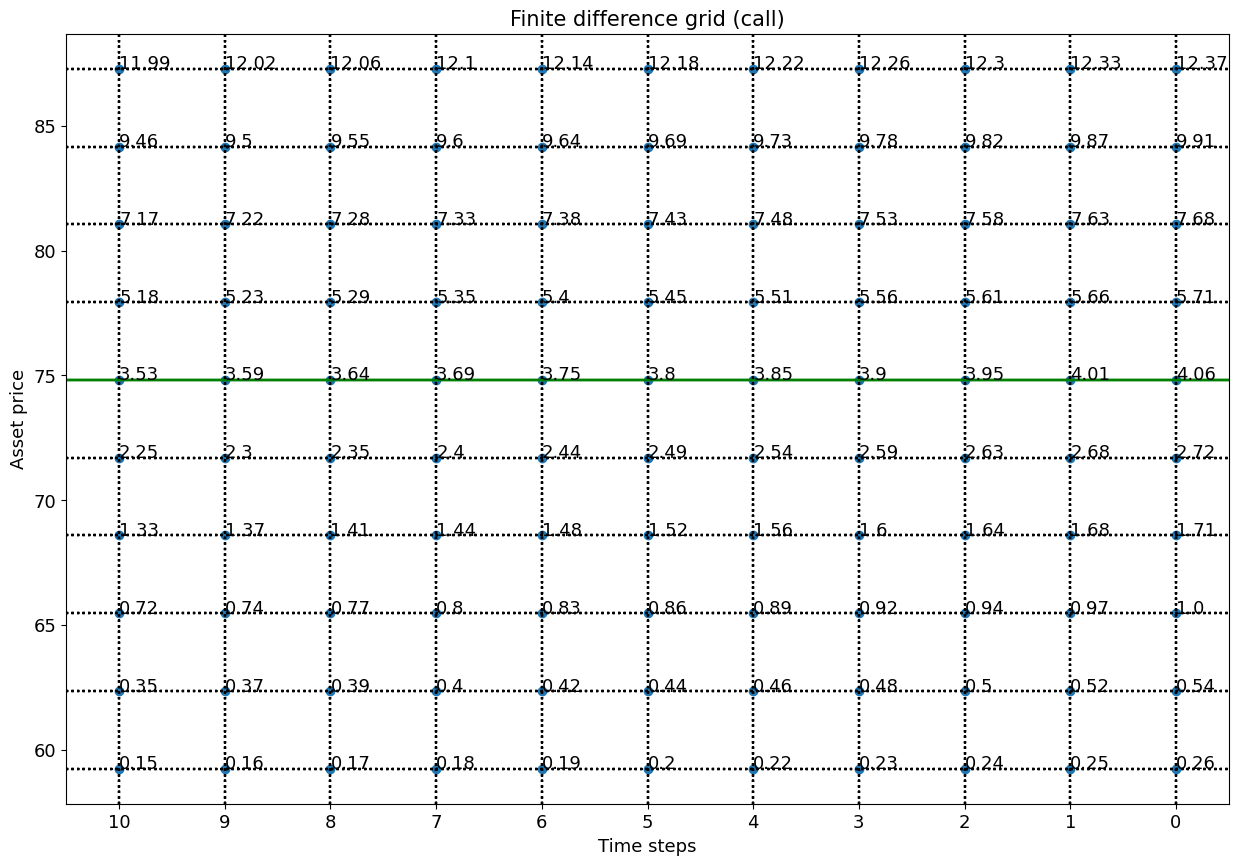

In [58]:
plt.figure(figsize=(15,10))
plt.scatter(x,y)
for i in range(n_y):
    for j in range(n_x):
        plt.annotate(labels[i,j],(x[i,j],y[i,j]),fontsize=13)
        if y[i,j]==S_0:
            plt.axhline(y[i,j],color='green',linestyle='solid')
        else:  
            plt.axhline(y[i,j],color='black',linestyle='dotted')
        plt.axvline(x[i,j],color='black',linestyle='dotted')
plt.xlabel(xlabel='Time steps',fontsize=13)    
plt.ylabel(ylabel='Asset price',fontsize=13)
plt.xticks(list(grid_call.columns[40:]),list(grid_call.columns[40:])[::-1],fontsize=13)
plt.yticks(fontsize=13)
plt.title('Finite difference grid (call)',fontsize=15)
plt.show()